# Quora Question Pairs Competition Notebook

### To Improve User (question seeker, answer writer) Satisfaction by buidling a model to improve model performance of low log loss.

In [400]:
# Import necessary libraries
import pandas as pd
import nltk
import re
import utilities as u
import numpy as np
import sklearn
import pickle
import collections
import keras
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.layers import Input, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from tensorflow.python.keras import utils
from gensim.models import KeyedVectors


#Check Keras and tensorflow version
print ("Importing modules and Loading word2vec pretrained embedding vector")
print("keras version is {}".format(keras.__version__))
print("tf version is {}".format(tf.__version__))


Importing modules and Loading word2vec pretrained embedding vector
keras version is 2.1.2
tf version is 1.4.1


In [5]:
# Load pretrained embedding vector trained on Google News
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# To check if word2vec embedding model is loaded succesfully
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

/Users/jac812i/virtualenvs/quoravenv/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071)]


In [11]:
# Read training and test data from .csv files
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")

/Users/jac812i/virtualenvs/quoravenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
# Display top 3 rows of train data
train_df.head(3)
# assert the shape of train dataframe
assert train_df.shape[0] > 0
assert train_df.shape[1] > 0

In [85]:
# Display top 3 rows of test data and assert test data shape
test_df.head(3)
assert test_df.shape[0] > 0
assert test_df.shape[1] > 0

# Identify Feature and Target columns

In [14]:
# Extract feature (X) and target (y) columns
feature_cols = list(train_df.columns[:-1])
target_col = train_df.columns[-1]
print ("Feature Columns {}".format(feature_cols))
print ("Target Columns {}".format(target_col))
X_all = train_df[feature_cols]
y_all = pd.DataFrame(data=train_df[target_col], columns=[target_col])

Feature Columns ['id', 'qid1', 'qid2', 'question1', 'question2']
Target Columns is_duplicate


In [15]:
# To check if the data is balanced or not
collections.Counter(y_all['is_duplicate'])

Counter({0: 255027, 1: 149263})

In [361]:
# To check if the data is balanced or not
non_duplicates = collections.Counter(y_all['is_duplicate'])[0]
duplicates = collections.Counter(y_all['is_duplicate'])[1]

print (non_duplicates)
print (duplicates)

255027
149263


In [363]:
percent_non_duplicates = non_duplicates/(non_duplicates+duplicates)
percent_duplicates = duplicates/(non_duplicates+duplicates)
print (percent_non_duplicates)
print (percent_duplicates)

0.630802146973707
0.369197853026293


In [16]:
# Check the 5 rows of train output
y_all.head(5)

,is_duplicate
0,0
1,0
2,0
3,0
4,0


In [22]:
# Check the 3 rows of the new dataframe
X_all.head(3)
# Assert the shapes are equal after removing the feature
assert X_all.shape == (train_df.shape[0],train_df.shape[1]-1)

# Split data in training and validation sets

In [61]:
# Split data into 70% training and 30% validation and have a constant random state so that the results are consistent
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.30, random_state=42)
print ("Total data set: {} samples".format(X_all.shape[0]))
print ("Training set: {} samples".format(X_train.shape[0]))
print ("Valid set: {} samples".format(X_valid.shape[0]))

Total data set: 404290 samples
Training set: 283003 samples
Valid set: 121287 samples


In [62]:
# asserting the shapes after splitting the data
assert (X_train.shape[0] + X_valid.shape[0]) == X_all.shape[0]
assert (y_train.shape[0] + y_valid.shape[0]) == y_all.shape[0]

# Check whether data is balanced or not

In [63]:
# TO check how many question pairs in training set are duplicate or not
collections.Counter(y_train['is_duplicate'])

Counter({0: 178677, 1: 104326})

In [64]:
# TO check how many question pairs in validation set are duplicate or not
collections.Counter(y_valid['is_duplicate'])

Counter({0: 76350, 1: 44937})

In [65]:

#Check few rows of X_valid
X_valid.head(3)

,id,qid1,qid2,question1,question2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?


In [66]:
#Check few rows of y_valid
y_valid.head(3)

,is_duplicate
8067,0
368101,0
70497,0


In [67]:
# Reset index to start from 0
X_train.reset_index(drop = True, inplace = True)
X_valid.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_valid.reset_index(drop = True, inplace = True)

#asserting shapes after resetting index
assert (X_train.shape[0] + X_valid.shape[0]) == X_all.shape[0]
assert (y_train.shape[0] + y_valid.shape[0]) == y_all.shape[0]

In [68]:

#Check few rows of X_valid
X_valid.head(3)

,id,qid1,qid2,question1,question2
0,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?
1,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...
2,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?


### Simple Data Preprocessing for Baseline

In [69]:
# Function that takes a text and preprocess it like converting to string, split the string etc

def preprocess_baseline_text(text):
    text = str(text)
    text = text.lower()
    text = text.split()
    
    return text


#Test the function
assert preprocess_baseline_text('How do I play Pokémon GO in Korea?') == ['how', 'do', 'i', 'play', 'pokémon', 'go', 'in', 'korea?']


In [77]:
print (X_valid[0:1])

     id   qid1   qid2                           question1  \
0  8067  15738  15739  How do I play Pokémon GO in Korea?   

                            question2  
0  How do I play Pokémon GO in China?  


In [83]:
# Function that returns a list of all the words from a dataframe

def create_vocabulary(words_list,df,column_name):
    for sentence in df[column_name]:
        for word in sentence:
            words_list.append(word)
    return words_list


#Test the function
data = [['How do I play Pokémon GO in Korea?']]
test_sub_df = pd.DataFrame(data,columns=['question1'])
test_sub_df['question1'] = test_sub_df['question1'].apply(lambda x: preprocess_baseline_text(x))

# assert the function is working fine with dataframe and column name
assert create_vocabulary([],test_sub_df,'question1') == ['how', 'do', 'i', 'play', 'pokémon', 'go', 'in', 'korea?']


In [104]:
# Create new dataframes and do data preprocessing on the question1 and question 2 columns
X_train_df = pd.DataFrame()
X_valid_df = pd.DataFrame()
X_train_df['question1'] = X_train['question1'].apply(lambda x:preprocess_baseline_text(x))
X_train_df['question2'] = X_train['question2'].apply(lambda x:preprocess_baseline_text(x))
X_valid_df['question1'] = X_valid['question1'].apply(lambda x:preprocess_baseline_text(x))
X_valid_df['question2'] = X_valid['question2'].apply(lambda x:preprocess_baseline_text(x))

#assertions on dataframe shape's
assert X_train_df.shape[0] == X_train.shape[0]
assert X_train_df.shape[1] == 2
assert X_valid_df.shape[0] == X_valid_df.shape[0]
assert X_valid_df.shape[1] == 2

In [105]:
# Check few rows of dataframe for manual validation
X_train_df.head(3)

,question1,question2
0,"[how, is, the, working, environment, at, sbi, ...","[how, stressful, is, work, of, sbi, clerk?]"
1,"[how, can, a, us, citizen, work, in, canada?]","[will, a, us, graduate, degree, help, a, non-u..."
2,"[what, are, the, benefits, of, washing, your, ...","[why, is, it, important, to, wash, your, hands..."


In [106]:
# Check few rows of dataframe for manual validation
X_valid_df.head(3)

,question1,question2
0,"[how, do, i, play, pokémon, go, in, korea?]","[how, do, i, play, pokémon, go, in, china?]"
1,"[what, are, some, of, the, best, side, dishes,...","[what, are, some, good, side, dishes, for, buf..."
2,"[which, is, more, advisable, and, better, mate...","[what, is, the, best, server, setup, for, budd..."


# Create a simple baseline model with Logistic Regression





### Preparing Features for Machine Learning Model.

####    Create a feature based on how many words are common in question 1 and question 2

In [107]:
# Function to calculate how many unique words are common between two question sentence's
def termfrequency(sentence1, sentence2):
   
    question_dict ={}
    sentence1_words = sentence1   
    sentence2_words = sentence2
    searchtermfreq = []
    
    for key in sentence1_words:
        question_dict[key] = question_dict.get(key,0) + 1
    
    for key in set(sentence2_words):
        value =  question_dict.get(key,0)
        if value >= 1:
            value = 1
        searchtermfreq.append(value)
        
    return sum(searchtermfreq)


#assertion to make sure term frequency function is working fine
assert termfrequency(['what', 'is', 'the', 'step', 'by', 'step'], ['what', 'is', 'the', 'step', 'by', 'step', 'guide']) == 5

In [130]:
#Creating a new column common_term_freq which has the value of unique words that are common between two question sentence's

X_train_df['common_term_freq'] = X_train_df.apply(lambda x: termfrequency(x['question1'],x['question2']), axis=1 )
X_valid_df['common_term_freq'] = X_valid_df.apply(lambda x: termfrequency(x['question1'],x['question2']), axis=1 )

# assert to make sure the column is a number
assert X_train_df['common_term_freq'].shape[0] == X_train_df.shape[0]
assert X_valid_df['common_term_freq'].shape[0] == X_valid_df.shape[0]
assert X_train_df['common_term_freq'][0] >- 0
assert X_valid_df['common_term_freq'][0] >- 0

### Creating features based on Total words frequency

In [131]:
#Function to calculate count of number of words in a sentence
def total_words_freq(sentence):
    return len(sentence)

assert total_words_freq(['what', 'is', 'the', 'step', 'by', 'step']) == 6

In [133]:
#Create two new column's question1_words_freq and question2_words_freq using the above function 
#to calculate count of number of words in a sentence 

X_train_df['question1_words_freq'] = X_train_df['question1'].map(lambda x: total_words_freq(x))
X_train_df['question2_words_freq'] = X_train_df['question2'].map(lambda x: total_words_freq(x))

X_valid_df['question1_words_freq'] = X_valid_df['question1'].map(lambda x: total_words_freq(x))
X_valid_df['question2_words_freq'] = X_valid_df['question2'].map(lambda x: total_words_freq(x))


# assert to make sure the column is a number
assert X_train_df['question1_words_freq'][0] >= 0
assert X_train_df['question2_words_freq'][0] >= 0
assert X_valid_df['question1_words_freq'][0] >= 0
assert X_valid_df['question2_words_freq'][0] >= 0



In [134]:
# Check few rows
X_train_df.head(3)


,question1,question2,common_term_freq,question1_words_freq,question2_words_freq
0,"[how, is, the, working, environment, at, sbi, ...","[how, stressful, is, work, of, sbi, clerk?]",3,9,7
1,"[how, can, a, us, citizen, work, in, canada?]","[will, a, us, graduate, degree, help, a, non-u...",7,8,20
2,"[what, are, the, benefits, of, washing, your, ...","[why, is, it, important, to, wash, your, hands...",4,10,10


In [135]:
# Check few rows
X_valid_df.head(3)

,question1,question2,common_term_freq,question1_words_freq,question2_words_freq
0,"[how, do, i, play, pokémon, go, in, korea?]","[how, do, i, play, pokémon, go, in, china?]",7,8,8
1,"[what, are, some, of, the, best, side, dishes,...","[what, are, some, good, side, dishes, for, buf...",6,11,9
2,"[which, is, more, advisable, and, better, mate...","[what, is, the, best, server, setup, for, budd...",2,16,8


### Dropping Columns

In [216]:
# Drop column's question1 and question2 since machine learning input requires columns with numbers
X_train_model_input = X_train_df.drop(['question1','question2'],axis =1)
X_valid_model_input = X_valid_df.drop(['question1','question2'],axis =1)

assert X_train_model_input.shape[1] == X_train_df.shape[1] - 2
assert X_valid_model_input.shape[1] == X_valid_df.shape[1] - 2

In [217]:
X_train_model_input.head(5)

,common_term_freq,question1_words_freq,question2_words_freq
0,3,9,7
1,7,8,20
2,4,10,10
3,12,14,15
4,2,15,23


In [223]:
X_valid_model_input.head(3)

,common_term_freq,question1_words_freq,question2_words_freq
0,7,8,8
1,6,11,9
2,2,16,8


### Scaling the input features

In [258]:
#Using standard scaler to fit and transform the training data
StandardScaler = preprocessing.StandardScaler()
X_train_model_input[['common_term_freq','question1_words_freq','question2_words_freq']] = StandardScaler.fit_transform(X_train_model_input[['common_term_freq','question1_words_freq','question2_words_freq']])
# print(StandardScaler)
# print(StandardScaler.mean_)
X_train_model_input.head(5)

,common_term_freq,question1_words_freq,question2_words_freq
0,-0.486316,-0.358172,-0.661590
1,0.804862,-0.542547,1.392203
2,-0.163522,-0.173797,-0.187638
3,2.418835,0.563704,0.602283
4,-0.809111,0.748079,1.866156


In [259]:
#Using standard scaler to transform the validation data
X_valid_model_input[['common_term_freq','question1_words_freq','question2_words_freq']] = StandardScaler.transform(X_valid_model_input[['common_term_freq','question1_words_freq','question2_words_freq']])
X_valid_model_input.head(5)

,common_term_freq,question1_words_freq,question2_words_freq
0,0.804862,-0.542547,-0.503606
1,0.482068,0.010578,-0.345622
2,-0.809111,0.932454,-0.503606
3,-0.163522,-0.726922,-0.345622
4,-0.486316,-0.358172,-0.661590


# Baseline Model Training and Evaluation

In [248]:
# Function that takes input, output and classifier to fit the model
def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    return clf
    
#Function that takes the fitted classifier for prediction and return log loss and confusion matrix
def predict_labels(clf, X_train, y_train):
    y_pred = clf.predict(X_train)
    labels = ['Duplicate Question', 'Not Duplicate Question']
    return log_loss(y_train, y_pred, eps=1e-15), confusion_matrix(y_train, y_pred)

# Use Logistic Regression as classifier
clf =  LogisticRegression()

# Fit Logistic Regression Classifier
clf_fit = train_classifier(clf, X_train_model_input, y_train.values.ravel())

# Predict on train data
train_metrics = predict_labels(clf_fit, X_train_model_input, y_train.values.ravel())
print ("Log loss for training set: {}".format(train_metrics[0]))
# print ("Confusion matrix for training set: {}".format(train_metrics[1]))
train_cm = train_metrics[1]


# Predict on Validation data
validation_metrics = predict_labels(clf_fit, X_valid_model_input, y_valid.values.ravel())
print ("Log loss for validation set: {}".format(validation_metrics[0]))
# print ("Confusion matrix for validation set: {}".format(validation_metrics[1]))



Log loss for training set: 11.942944153908059
Log loss for validation set: 12.033583121165355


In [249]:
#Print Classification coefficient and Intercepts
print ("Classification Coefficients are {}".format(clf_fit.coef_))
print ("Classification Intercept is {}".format(clf_fit.intercept_))


Classification Coefficients are [[ 0.89421766 -0.51337388 -0.62101507]]
Classification Intercept is [-0.68916547]


In [250]:
# Function to plot confustion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Confusion matrix for Training data

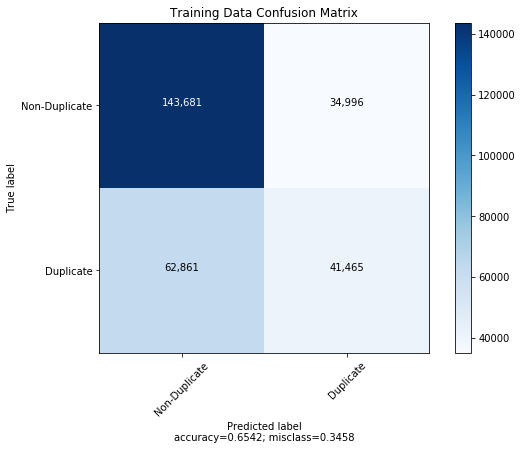

In [356]:

plot_confusion_matrix(cm           = train_metrics[1], 
                      normalize    = False,
                      target_names = ['Non-Duplicate', 'Duplicate'],
                      title        = "Training Data Confusion Matrix")

# Confusion matrix for Validation data using Logistic Regression

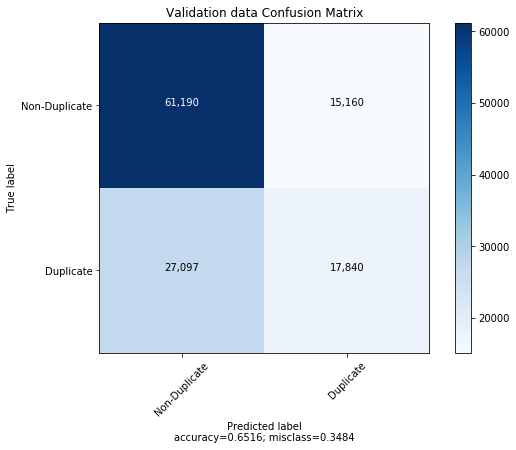

In [357]:

plot_confusion_matrix(cm           = validation_metrics[1], 
                      normalize    = False,
                      target_names = ['Non-Duplicate', 'Duplicate'],
                      title        = "Validation data Confusion Matrix")

# To check how many top frequent 10000 words in complete vocabulary are in word2vec 

In [256]:
# Create complete vocabulary from all the data using training and test data.

words_list = create_vocabulary([],X_all_1,'question1')
print ("Length of words after adding training data question 1 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_all_1,'question2')
print ("Length of words after adding training data question 2 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,test_df_1,'question1')
print ("Length of words after adding test data question 1 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,test_df_1,'question2')
print ("Length of words after adding test data question 2 {}".format(len(words_list)))

# asserting to check words list calculation did not provide empty records
assert len(words_list) > 0

Length of words after adding training data question 1 4423826
Length of words after adding training data question 2 8944593
Length of words after adding test data question 1 48146246
Length of words after adding test data question 2 87470531


In [255]:
# To check how many top frequent 10000 words in complete vocabulary are in word2vec after basic preprocessing of text

print ("Total count of unique words in vocabulary {}".format(len(set(words_list))))
words_freq = collections.Counter(words_list)
words_freq.most_common(10)
words_freq_10000 = words_freq.most_common(10000)


word_in_word2vec = []
word_notin_word2vec = []

for word in words_freq.most_common(10000):
    if word[0] in model.vocab:
        word_in_word2vec.append(word[0])
    else:
        word_notin_word2vec.append(word[0])
        
print ("Out of 10000 top frequent words {} words are present in word2vec after basic preprocessing of text".format(len(word_in_word2vec)))
print ("Out of 10000 top frequent words {} words are not present in word2vec after basic preprocessing of text".format(len(word_notin_word2vec)))

     
        

Total count of unique words in vocabulary 327522
Out of 10000 top frequent words 6614 words are present in word2vec after basic preprocessing of text
Out of 10000 top frequent words 3386 words are not present in word2vec after basic preprocessing of text


In [261]:
print ("Top 100 words from hightly frequent words in vocabulary present in word2vec {}".format(words_freq_10000[0:100]))

Top 100 words from hightly frequent words in vocabulary present in word2vec [('the', 3398855), ('what', 2980203), ('is', 2573361), ('how', 2090590), ('i', 2060339), ('a', 2028806), ('in', 1944305), ('to', 1898636), ('of', 1467452), ('do', 1374660), ('are', 1294421), ('and', 1223643), ('can', 1072247), ('for', 1012448), ('why', 707330), ('you', 699351), ('my', 666512), ('best', 632025), ('it', 581168), ('on', 547035), ('does', 521099), ('which', 466737), ('or', 461708), ('if', 408308), ('get', 386807), ('with', 384513), ('be', 375348), ('should', 372922), ('an', 362490), ('have', 361547), ('that', 357477), ('some', 351606), ('from', 325810), ('your', 272379), ('when', 258746), ('will', 250735), ('who', 247316), ('at', 246414), ('good', 233478), ('like', 223882), ('there', 214642), ('people', 212807), ('as', 210562), ('would', 208053), ('between', 196776), ('where', 190411), ('one', 181467), ('about', 178274), ('most', 171376), ('way', 167888), ('make', 167313), ('any', 165852), ('not', 

In [263]:
print ("Top 100 words from hightly frequent words in vocabulary not present in word2vec {}".format(word_notin_word2vec[0:100]))


Top 100 words from hightly frequent words in vocabulary not present in word2vec ['a', 'to', 'of', 'and', 'india?', 'quora', 'quora?', 'why?', 'life?', 'it?', "i'm", 'do?', 'time?', 'me?', 'english?', '2016?', 'mean?', 'online?', 'work?', '?', '10', 'instagram', 'you?', '2016', 'world?', '500', 'them?', 'engineering?', '1000', 'weight?', 'money?', 'account?', 'like?', 'whatsapp', 'not?', 'exam?', 'for?', 'language?', 'possible?', 'this?', 'sentence?', 'people?', 'day?', 'phone?', '-', 'number?', 'us?', 'sydney?', 'skills?', 'now?', 'country?', 'sex?', 'so,', 'instagram?', 'system?', 'facebook?', 'in?', 'free?', 'university?', 'job?', 'business?', 'movies?', 'bangalore?', 'year?', 'from?', 'person?', 'love?', 'about?', '2017?', 'college?', 'company?', 'water?', 'u.s.', 'programming?', 'companies?', 'exist?', 'app?', 'china?', 'fat?', 'card?', 'website?', 'years?', 'youtube?', 'how?', 'delhi?', 'one?', 'have?', 'science?', '/', 'girl?', "someone's", 'usa?', '12', 'be?', 'school?', "i've",

# Further Preprocessing Text

In [265]:
# As you can see from above there are many words that are not present in word2vec
#and some of them are time?, someone's etc so further text preprocessing is required.

In [273]:
# Function to preprocess text
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    
    text = re.sub(r"[^A-Za-z0-9^?,!.\/'+-=]", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\?", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = text.split()
    
    return text

assert preprocess_text('What is= the step by step guide to invest in?') == ['what', 'is', '=', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in']

In [274]:
# Creating empty dataframes so that we can assign the new preprocessed text data
X_train_df = pd.DataFrame()
X_valid_df = pd.DataFrame()
X_test_df = pd.DataFrame()

In [275]:
X_train.head(3)

,id,qid1,qid2,question1,question2
0,20128,37998,37999,"How is the working environment at SBI Life, Mu...",How stressful is work of SBI clerk?
1,296237,418414,31812,How can a US citizen work in Canada?,Will a US graduate degree help a non-US citize...
2,107095,176273,176274,What are the benefits of washing your hands wi...,Why is it important to wash your hands with soap?


In [277]:
X_valid.head(3)

,id,qid1,qid2,question1,question2
0,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?
1,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...
2,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?


In [276]:
test_df.head(3)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?


In [278]:
#Creating new pandas dataframe applying preprocess_text function
X_train_df['question1'] = X_train['question1'].apply(lambda x:preprocess_text(x))
X_train_df['question2'] = X_train['question2'].apply(lambda x:preprocess_text(x))
X_valid_df['question1'] = X_valid['question1'].apply(lambda x:preprocess_text(x))
X_valid_df['question2'] = X_valid['question2'].apply(lambda x:preprocess_text(x))
X_test_df['question1'] = test_df['question1'].apply(lambda x:preprocess_text(x))
X_test_df['question2'] = test_df['question2'].apply(lambda x:preprocess_text(x))

In [279]:
X_train_df.head(3)

,question1,question2
0,"[how, is, the, working, environment, at, sbi, ...","[how, stressful, is, work, of, sbi, clerk]"
1,"[how, can, a, us, citizen, work, in, canada]","[will, a, us, graduate, degree, help, a, non, ..."
2,"[what, are, the, benefits, of, washing, your, ...","[why, is, it, important, to, wash, your, hands..."


In [281]:
words_list = create_vocabulary([],X_train_df,'question1')
print ("Lenght of words in X_train_df question 1 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_train_df,'question2')
print ("Lenght of words after adding X_train_df question 2 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_valid_df,'question1')
print ("Lenght of words after adding X_valid_df question 1 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_valid_df,'question2')
print ("Lenght of words after adding X_valid_df question 2 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_test_df,'question1')
print ("Lenght of words after adding X_test_df question 1 {}".format(len(words_list)))
words_list = create_vocabulary(words_list,X_test_df,'question2')
print ("Lenght of words after adding X_test_df question 2 {}".format(len(words_list)))

Lenght of words in X_train_df question 1 3143028
Lenght of words after adding X_train_df question 2 6358368
Lenght of words after adding X_valid_df question 1 7705257
Lenght of words after adding X_valid_df question 2 9080346
Lenght of words after adding X_test_df question 1 48938305
Lenght of words after adding X_test_df question 2 88928769


In [284]:
# print (len(set(words_list)))
# print (words_list[0:10])
words_freq = collections.Counter(words_list)
words_freq.most_common(10)
words_freq_10000 = words_freq.most_common(10000)


word_in_word2vec = []
word_notin_word2vec = []

for word in words_freq.most_common(10000):
    if word[0] in model.vocab:
        word_in_word2vec.append(word[0])
    else:
        word_notin_word2vec.append(word[0])
        
print ("Out of 10000 top frequent words {} words are present in word2vec after basic preprocessing of text".format(len(word_in_word2vec)))
print ("Out of 10000 top frequent words {} words are not present in word2vec after basic preprocessing of text".format(len(word_notin_word2vec)))


Out of 10000 top frequent words 9206 words are present in word2vec after basic preprocessing of text
Out of 10000 top frequent words 794 words are not present in word2vec after basic preprocessing of text


### Based on above after data preprocessing the number of words present in word2vec increased to 9206 from 6614 

In [285]:
print (word_notin_word2vec[0:100]) 

['a', 'to', 'of', 'and', '-', 'quora', '2016', '10', 'instagram', '500', '1000', 'whatsapp', '2017', '2015', 'snapchat', '20', ':', '12', '100', '000', '15', '30', '50', 'jio', '12th', 'sbi', '16', '11', 'brexit', '!', '18', 'upsc', 'ece', '13', 'tcs', 'narendra', 'better:', '2014', '25', '17', '14', '70', 'mbbs', 'manipal', '2000', 'gmat', '40', 'iim', '24', 'btech', 'cgpa', '200', 'iiit', 'cgl', '10th', 'obc', 'redmi', 'favourite', '90', '60', 'iits', '21', 'pilani', 'aiims', 'centre', 'mightn', '80', 'flipkart', 'mustn', 'xiaomi', '19', 'travelling', 'ielts', '22', '300', 'india:', 'bba', 'colour', 'ibps', '23', 'ps4', '2013', 'mtech', 'accenture', 'x^2', 'paytm', '25000', 'elon', 'hadoop', 'kohli', 'srm', 'kejriwal', 'bitsat', 'spotify', '11th', 'grey', "'", '32', 'ncr', 'virat']


# LSTM Implementation

In [292]:
# Creating words to index and index to words dictionary for words_list
words_to_index = {}
index_to_words = {}

i = 0
for word in set(words_list):
    words_to_index[word] = i
    i = i + 1
    
j=0
for word in set(words_list):
    index_to_words[j] = word
    j=j+1

print (words_to_index['the'])
print (index_to_words[words_to_index['the']])
assert words_to_index['the'] == words_to_index[index_to_words[words_to_index['the']]]

83547
the


### Saving the words_to_index and index_to_words dictionary as pickle for model implementation in other environments

In [287]:
import pickle
with open('words_to_index_v3.pickle', 'wb') as handle:
    pickle.dump(words_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('index_to_words_v3.pickle', 'wb') as handle:
    pickle.dump(index_to_words, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    

In [293]:
# Function to convert words to integer
def word_2_integer(wordslist):
    question2integer = []
    for word in wordslist:
        question2integer.append(words_to_index[word])

    return question2integer

word_2_integer(['what', 'is', 'the', 'story', 'of', 'kohinoor'])

[56489, 48871, 83547, 3746, 129049, 88186]

In [294]:
# Apply word_2_integer function on the question 1 and 2 columns in dataframe
X_train_df['question1'] = X_train_df['question1'].apply(lambda x:word_2_integer(x))
X_train_df['question2'] = X_train_df['question2'].apply(lambda x:word_2_integer(x))
X_valid_df['question1'] = X_valid_df['question1'].apply(lambda x:word_2_integer(x))
X_valid_df['question2'] = X_valid_df['question2'].apply(lambda x:word_2_integer(x))
X_test_df['question1'] = X_test_df['question1'].apply(lambda x:word_2_integer(x))
X_test_df['question2'] = X_test_df['question2'].apply(lambda x:word_2_integer(x))

In [295]:
X_train_df['question1'].head(5)

0    [78025, 48871, 83547, 89485, 27102, 2475, 1300...
1    [78025, 111498, 110740, 87881, 49411, 49880, 8...
2    [56489, 127405, 83547, 88555, 129049, 124082, ...
3    [78025, 45884, 83547, 27214, 29349, 129049, 10...
4    [48871, 83547, 49294, 21971, 24023, 73612, 127...
Name: question1, dtype: object

### Create Embedding matrix

In [299]:
# Create embedding vector of size 300 as word2vec vector has 300 dimensions and create random vector of 
#size len(words_to_index)+1 * 300

embed_length = 300
embed_matrix = np.random.randn(len(words_to_index)+1,embed_length)
# To ignore padding vector of 300 zero's
embed_matrix[0] = 0

assert embed_matrix.shape == (len(words_to_index)+1,embed_length)

In [300]:
print (embed_matrix.shape)

(131744, 300)


In [306]:
#Updating embedding matrix 
count = 0
for word, index in words_to_index.items():
    if word in model.vocab:
        count = count + 1
        embed_matrix[index] = model.word_vec(word)


print ("Out of {} words {} index got updated from word2vec".format(len(words_to_index),count))        


Out of 131743 words 58547 index got updated from word2vec


### Convert output to categorical values

In [315]:
# Convert labels to their numpy representations
Y_train =  y_train.values
Y_valid =  y_valid.values


In [316]:
print (Y_train[0:10])

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]


In [317]:
# Convert output to categorical values
Y_train = utils.to_categorical(Y_train, num_classes=2)
Y_valid = utils.to_categorical(Y_valid, num_classes=2)

### Preparing Input data for the Neural Network Architecture

In [318]:
#Find the maximum sequence length from all the sentences in train and test
max_seq_length = max([
max(list(X_train_df['question1'].map(lambda x: len(x)))),
max(list(X_train_df['question2'].map(lambda x: len(x)))),
max(list(X_valid_df['question1'].map(lambda x: len(x)))),
max(list(X_valid_df['question2'].map(lambda x: len(x)))),
max(list(X_test_df['question1'].map(lambda x: len(x)))),
max(list(X_test_df['question2'].map(lambda x: len(x)))),
])

print ("Maximum sequence length is {}".format(max_seq_length))
assert max_seq_length > 0

Maximum sequence length is 242


In [319]:
X_train_df['question1'][0]

[78025, 48871, 83547, 89485, 27102, 2475, 130082, 35463, 99128]

In [324]:
# Function to pad zero's in the left
def pad_left_zeros(question_list,max_seq_length):
    question_list = [0] * (max_seq_length - len(question_list)) + question_list
    return question_list

assert len (pad_left_zeros([31586, 69984, 104295, 57112, 55384, 21628, 63296, 131479, 95639],max_seq_length)) == max_seq_length

In [325]:
# Applying padding zero's to the left for all the dataframes columns
X_train_df['question1'] = X_train_df['question1'].apply(lambda x: pad_left_zeros(x,max_seq_length))
X_train_df['question2'] = X_train_df['question2'].apply(lambda x: pad_left_zeros(x,max_seq_length))
X_valid_df['question1'] = X_valid_df['question1'].apply(lambda x: pad_left_zeros(x,max_seq_length))
X_valid_df['question2'] = X_valid_df['question2'].apply(lambda x: pad_left_zeros(x,max_seq_length))
X_test_df['question1'] = X_test_df['question1'].apply(lambda x: pad_left_zeros(x,max_seq_length))
X_test_df['question2'] = X_test_df['question2'].apply(lambda x: pad_left_zeros(x,max_seq_length))

In [326]:
# Split to dicts so that we can send this as left and right input to LSTM Neural Network
X_train_dict = {'left': X_train_df['question1'], 'right': X_train_df['question2']}
X_valid_dict = {'left': X_valid_df['question1'], 'right': X_valid_df['question2']}
X_test_dict = {'left': X_test_df['question1'], 'right': X_test_df['question2']}

In [331]:
# Reshaping the numpy array to batchsize(Number of training data),max_seq_length

X_train_dict['left'] = np.concatenate(X_train_dict['left']).reshape(X_train_dict['left'].shape[0],max_seq_length)
X_train_dict['right'] = np.concatenate(X_train_dict['right']).reshape(X_train_dict['right'].shape[0],max_seq_length)

assert X_train_dict['left'].shape == (X_train_dict['left'].shape[0],max_seq_length)
assert X_train_dict['right'].shape == (X_train_dict['right'].shape[0],max_seq_length)

In [334]:
print ("Input Training vector shape to LSTM Neural Network is {}".format(X_train_dict['left'].shape))

Input Training vector shape to LSTM Neural Network is (283003, 242)


In [332]:
# Reshaping the numpy array to batchsize(Number of validation data),max_seq_length

X_valid_dict['left'] = np.concatenate(X_valid_dict['left']).reshape(X_valid_dict['left'].shape[0],max_seq_length)
X_valid_dict['right'] = np.concatenate(X_valid_dict['right']).reshape(X_valid_dict['right'].shape[0],max_seq_length)

assert X_valid_dict['left'].shape == (X_valid_dict['left'].shape[0],max_seq_length)
assert X_valid_dict['right'].shape == (X_valid_dict['right'].shape[0],max_seq_length)

In [335]:
print ("Input Validation vector shape to LSTM Neural Network is {}".format(X_valid_dict['left'].shape))

Input Validation vector shape to LSTM Neural Network is (121287, 242)


In [336]:
assert X_train_dict['left'].shape == X_train_dict['right'].shape
assert len(X_train_dict['left']) == len(Y_train)

## Deep Learning Shared LSTM Merged Neural Network Model with one output dense layer at the end

In [378]:
# Implementing Keras Functional API as we are having multiple inputs to Neural Network architecture

#Left and Right Input of shape None,max_seq_length
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Add embedding Layer with no training
embedding_layer = Embedding(len(embed_matrix),
                            embed_length,
                            weights=[embed_matrix],
                            input_length=max_seq_length,
                            trainable=False)

#Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# encoded_left.shape

# This layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

#output vector
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


# left_output.shape
# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([left_output,right_output], axis=-1)

#Pass the concatenate vector to dense layer for prediction
predictions = Dense(2, activation='softmax')(merged_vector)

#Creating the model
model = Model(inputs=[left_input, right_input], outputs=predictions)

#Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Model Training and Evaluation

In [379]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_iter_1 = model.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))



Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1466s 5ms/step - loss: 0.5558 - acc: 0.7157 - val_loss: 0.5311 - val_acc: 0.7339
Epoch 2/4
283003/283003 [==============================] - 1387s 5ms/step - loss: 0.5143 - acc: 0.7464 - val_loss: 0.5128 - val_acc: 0.7483
Epoch 3/4
283003/283003 [==============================] - 1372s 5ms/step - loss: 0.4903 - acc: 0.7616 - val_loss: 0.5067 - val_acc: 0.7522
Epoch 4/4
283003/283003 [==============================] - 1370s 5ms/step - loss: 0.4712 - acc: 0.7736 - val_loss: 0.5006 - val_acc: 0.7579


In [380]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_iter_2 = model.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))

Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1370s 5ms/step - loss: 0.4631 - acc: 0.7778 - val_loss: 0.5005 - val_acc: 0.7578
Epoch 2/4
283003/283003 [==============================] - 1370s 5ms/step - loss: 0.4380 - acc: 0.7918 - val_loss: 0.4964 - val_acc: 0.7649
Epoch 3/4
283003/283003 [==============================] - 1368s 5ms/step - loss: 0.4230 - acc: 0.8002 - val_loss: 0.4992 - val_acc: 0.7659
Epoch 4/4
283003/283003 [==============================] - 1371s 5ms/step - loss: 0.4109 - acc: 0.8082 - val_loss: 0.5027 - val_acc: 0.7669


In [381]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_iter_3 = model.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))

Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1369s 5ms/step - loss: 0.3971 - acc: 0.8143 - val_loss: 0.5094 - val_acc: 0.7668
Epoch 2/4
283003/283003 [==============================] - 1367s 5ms/step - loss: 0.3856 - acc: 0.8213 - val_loss: 0.5170 - val_acc: 0.7650
Epoch 3/4
283003/283003 [==============================] - 1365s 5ms/step - loss: 0.3752 - acc: 0.8269 - val_loss: 0.5236 - val_acc: 0.7660
Epoch 4/4
283003/283003 [==============================] - 1365s 5ms/step - loss: 0.4077 - acc: 0.8153 - val_loss: 0.5264 - val_acc: 0.7664


In [382]:
# Capturing the acc and val_acc for differente epochs as a list so that we can plot the graph
model_iter_acc = model_iter_1.history['acc'] + model_iter_2.history['acc'] + model_iter_3.history['acc']
model_iter_val_acc = model_iter_1.history['val_acc'] + model_iter_2.history['val_acc'] + model_iter_3.history['val_acc']

In [383]:
# Capturing the loss and val_loss for differente epochs as a list so that we can plot the graph
model_iter_loss = model_iter_1.history['loss'] + model_iter_2.history['loss'] + model_iter_3.history['loss']
model_iter_val_loss = model_iter_1.history['val_loss'] + model_iter_2.history['val_loss'] + model_iter_3.history['val_loss']

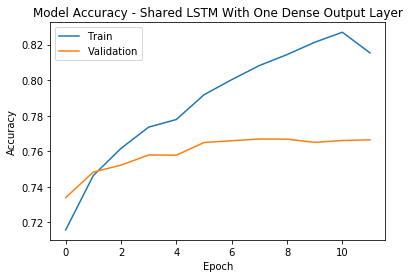

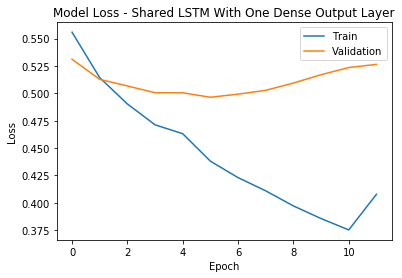

In [430]:
# Plot accuracy
plt.plot(model_iter_acc)
plt.plot(model_iter_val_acc)
plt.title('Model Accuracy - Shared LSTM With One Dense Output Layer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(model_iter_loss)
plt.plot(model_iter_val_loss)
plt.title('Model Loss - Shared LSTM With One Dense Output Layer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Save the model

In [ ]:
# save the model
# Epochs 12
model.save("../quora_keras_model_v3.hdf5")

In [392]:
# Function that takes input question pair, preprocess_text function and words_to_index dictionary and outputs 
#input vector to be passed on to neural network
def preprocess_model_input(input_questions,preprocess_text,words_to_index):

    final_new_words_list = []

    # i = 0
    for words_list in input_questions:
        new_words_list = []
      
        for word in preprocess_text(words_list):

            if words_to_index.get(word):
                new_words_list.append(words_to_index.get(word))
             
        final_new_words_list.append(np.array(pad_left_zeros(new_words_list,max_seq_length)))
        
         
    return [final_new_words_list[0].reshape(1,max_seq_length), final_new_words_list[1].reshape(1,max_seq_length)]


input_questions = ["How can I be a good geologist?", "What should I do to be a great geologist?"]
assert preprocess_model_input(input_questions,preprocess_text,words_to_index)[0].shape == (1,max_seq_length)
assert preprocess_model_input(input_questions,preprocess_text,words_to_index)[1].shape == (1,max_seq_length)

In [398]:
## Function that takes saved model, input_questions pair, preprocess_model_input function, preprocess_text function 
## and words_to_index dictionary and outputs the predicted probability for classes

def model_prediction(model,input_questions,preprocess_model_input,preprocess_text,words_to_index):
    y_prob = model.predict(preprocess_model_input(input_questions,preprocess_text,words_to_index),batch_size=1, verbose=0, steps=None)

    print ("The probabilities predicted by model for the question pair \n {} for classes [0,1] are \n {}".format(input_questions,y_prob))
    y_classes = y_prob.argmax(axis=-1)
    print ("The class that model predicted for the question pair \n {} is {}".format(input_questions,y_classes))
    return y_classes

# using duplicate example
input_questions = ["How can I be a good geologist?", "What should I do to be a great geologist?"]
assert model_prediction(model,input_questions,preprocess_model_input,preprocess_text,words_to_index).shape == (1,)

The probabilities predicted by model for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] for classes [0,1] are 
 [[0.11011977 0.88988024]]
The class that model predicted for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] is [1]


In [399]:
#Using one non duplicate example
input_questions = ["Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?", "Which fish would survive in salt water?"]
model_prediction(model,input_questions,preprocess_model_input,preprocess_text,words_to_index)


The probabilities predicted by model for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] for classes [0,1] are 
 [[0.99610424 0.00389581]]
The class that model predicted for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] is [0]


array([0])

## Using the Saved Model for Future Model Use in Production or Other Environments

In [ ]:
# Open saved model and words_to_index dictionary for predictions

In [401]:
#Load the saved Keras model
predict_model = load_model("../quora_keras_model_v3.hdf5")

In [402]:
#Load the words_to_index dictionary
with open('words_to_index_v3.pickle', 'rb') as handle:
    words_to_index_1 = pickle.load(handle)

In [403]:
#Load the index_to_words dictionary
with open('index_to_words_v3.pickle', 'rb') as handle:
    index_to_words_1 = pickle.load(handle)

In [426]:
#Using one non duplicate example
input_questions = ["Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?", "Which fish would survive in salt water?"]
model_prediction(predict_model,input_questions,preprocess_model_input,preprocess_text,words_to_index_1)



The probabilities predicted by model for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] for classes [0,1] are 
 [[0.99610424 0.00389581]]
The class that model predicted for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] is [0]


array([0])

In [427]:
#Using one duplicate example
input_questions = ["How can I be a good geologist?", "What should I do to be a great geologist?"]
model_prediction(predict_model,input_questions,preprocess_model_input,preprocess_text,words_to_index_1)

The probabilities predicted by model for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] for classes [0,1] are 
 [[0.11011977 0.88988024]]
The class that model predicted for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] is [1]


array([1])

## Increasing model layers to see if increase layers increase model performance
## Deep Learning Shared LSTM Merged Neural Network Model with more dense layers

In [411]:
# Implementing Keras Functional API as we are having multiple inputs to Neural Network architecture

#Left and Right Input of shape None,max_seq_length
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Add embedding Layer with no training
embedding_layer = Embedding(len(embed_matrix),
                            embed_length,
                            weights=[embed_matrix],
                            input_length=max_seq_length,
                            trainable=False)

#Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# encoded_left.shape

# This layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

#output vector
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


# left_output.shape
# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([left_output,right_output], axis=-1)

# Adding more dense layers 
merged_vector = Dense(64, activation='relu')(merged_vector)
merged_vector = Dense(64, activation='relu')(merged_vector)
merged_vector = Dense(64, activation='relu')(merged_vector)

#Pass the concatenate vector to dense layer for prediction
predictions = Dense(2, activation='softmax')(merged_vector)

#Creating the model
model_dense = Model(inputs=[left_input, right_input], outputs=predictions)

#Compile the model
model_dense.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



## Model Training and Evaluation

In [412]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_dense_iter_1 = model_dense.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))




Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1502s 5ms/step - loss: 0.5128 - acc: 0.7399 - val_loss: 0.4647 - val_acc: 0.7750
Epoch 2/4
283003/283003 [==============================] - 1418s 5ms/step - loss: 0.4347 - acc: 0.7917 - val_loss: 0.4310 - val_acc: 0.7956
Epoch 3/4
283003/283003 [==============================] - 1385s 5ms/step - loss: 0.3948 - acc: 0.8163 - val_loss: 0.4207 - val_acc: 0.8035
Epoch 4/4
283003/283003 [==============================] - 1388s 5ms/step - loss: 0.3669 - acc: 0.8314 - val_loss: 0.4129 - val_acc: 0.8061


In [413]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_dense_iter_2 = model_dense.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))

Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1371s 5ms/step - loss: 0.3437 - acc: 0.8440 - val_loss: 0.4166 - val_acc: 0.8132
Epoch 2/4
283003/283003 [==============================] - 1372s 5ms/step - loss: 0.3248 - acc: 0.8535 - val_loss: 0.4151 - val_acc: 0.8164
Epoch 3/4
283003/283003 [==============================] - 1368s 5ms/step - loss: 0.3080 - acc: 0.8628 - val_loss: 0.4130 - val_acc: 0.8136
Epoch 4/4
283003/283003 [==============================] - 1370s 5ms/step - loss: 0.2928 - acc: 0.8706 - val_loss: 0.4293 - val_acc: 0.8189


In [414]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_dense_iter_3 = model_dense.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))

Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1371s 5ms/step - loss: 0.2793 - acc: 0.8772 - val_loss: 0.4275 - val_acc: 0.8191
Epoch 2/4
283003/283003 [==============================] - 1369s 5ms/step - loss: 0.2664 - acc: 0.8838 - val_loss: 0.4298 - val_acc: 0.8217
Epoch 3/4
283003/283003 [==============================] - 1385s 5ms/step - loss: 0.2544 - acc: 0.8901 - val_loss: 0.4325 - val_acc: 0.8207
Epoch 4/4
283003/283003 [==============================] - 1406s 5ms/step - loss: 0.2431 - acc: 0.8953 - val_loss: 0.4598 - val_acc: 0.8199


In [415]:
# Run the model with 4 epochs and measure the log loss and accuracy on validation data
n_epoch = 4

model_dense_iter_4 = model_dense.fit([X_train_dict['left'], X_train_dict['right']], Y_train, batch_size=128, epochs=n_epoch,
         validation_data=([X_valid_dict['left'], X_valid_dict['right']], Y_valid))

Train on 283003 samples, validate on 121287 samples
Epoch 1/4
283003/283003 [==============================] - 1564s 6ms/step - loss: 0.2336 - acc: 0.9003 - val_loss: 0.4602 - val_acc: 0.8222
Epoch 2/4
283003/283003 [==============================] - 1636s 6ms/step - loss: 0.2246 - acc: 0.9052 - val_loss: 0.4950 - val_acc: 0.8231
Epoch 3/4
283003/283003 [==============================] - 1371s 5ms/step - loss: 0.2157 - acc: 0.9090 - val_loss: 0.5328 - val_acc: 0.8222
Epoch 4/4
283003/283003 [==============================] - 1367s 5ms/step - loss: 0.2073 - acc: 0.9129 - val_loss: 0.5049 - val_acc: 0.8182


In [416]:
# Capturing the acc and val_acc for differente epochs as a list so that we can plot the graph
model_dense_iter_acc = model_dense_iter_1.history['acc'] + model_dense_iter_2.history['acc'] + model_dense_iter_3.history['acc'] + model_dense_iter_4.history['acc']
model_dense_iter_val_acc = model_dense_iter_1.history['val_acc'] + model_dense_iter_2.history['val_acc'] + model_dense_iter_3.history['val_acc'] + model_dense_iter_4.history['val_acc']

In [417]:
# Capturing the loss and val_loss for differente epochs as a list so that we can plot the graph
model_dense_iter_loss = model_dense_iter_1.history['loss'] + model_dense_iter_2.history['loss'] + model_dense_iter_3.history['loss'] + model_dense_iter_4.history['loss']
model_dense_iter_val_loss = model_dense_iter_1.history['val_loss'] + model_dense_iter_2.history['val_loss'] + model_dense_iter_3.history['val_loss'] + model_dense_iter_4.history['val_loss']

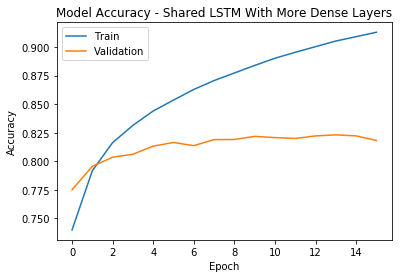

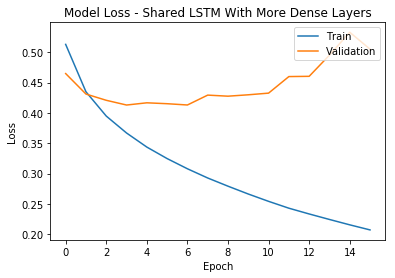

In [418]:
# Plot accuracy
plt.plot(model_dense_iter_acc)
plt.plot(model_dense_iter_val_acc)
plt.title('Model Accuracy - Shared LSTM With More Dense Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(model_dense_iter_loss)
plt.plot(model_dense_iter_val_loss)
plt.title('Model Loss - Shared LSTM With More Dense Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [419]:
#Using one non duplicate example
input_questions = ["Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?", "Which fish would survive in salt water?"]
model_prediction(model_dense,input_questions,preprocess_model_input,preprocess_text,words_to_index)

The probabilities predicted by model for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] for classes [0,1] are 
 [[9.996377e-01 3.622632e-04]]
The class that model predicted for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] is [0]


array([0])

In [420]:
#Using one duplicate example
input_questions = ["How can I be a good geologist?", "What should I do to be a great geologist?"]
model_prediction(model_dense,input_questions,preprocess_model_input,preprocess_text,words_to_index)

The probabilities predicted by model for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] for classes [0,1] are 
 [[0.16992822 0.83007175]]
The class that model predicted for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] is [1]


array([1])

### Save the Model With More Dense Layers

In [422]:
# save the model with name model_dense
# Epochs 16
model_dense.save("../quora_keras_model_dense_v3.hdf5")

### Using the Saved Model for Future Model Use in Production or Other Environments

In [423]:
#Load the saved Keras model
predict_model_dense = load_model("../quora_keras_model_dense_v3.hdf5")

In [424]:
#Load the words_to_index dictionary
with open('words_to_index_v3.pickle', 'rb') as handle:
    words_to_index_dense = pickle.load(handle)

In [425]:
#Using one non duplicate example
input_questions = ["Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?", "Which fish would survive in salt water?"]
model_prediction(predict_model_dense,input_questions,preprocess_model_input,preprocess_text,words_to_index_dense)

The probabilities predicted by model for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] for classes [0,1] are 
 [[9.996377e-01 3.622632e-04]]
The class that model predicted for the question pair 
 ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?'] is [0]


array([0])

In [428]:
#Using one duplicate example
input_questions = ["How can I be a good geologist?", "What should I do to be a great geologist?"]
model_prediction(predict_model_dense,input_questions,preprocess_model_input,preprocess_text,words_to_index_dense)

The probabilities predicted by model for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] for classes [0,1] are 
 [[0.16992822 0.83007175]]
The class that model predicted for the question pair 
 ['How can I be a good geologist?', 'What should I do to be a great geologist?'] is [1]


array([1])

# Conclusion:

### As shown from the above Notebook we were able to increase the model performance by reducing the validation log loss to. 0.5049 using Shared LSTM merged model with more dense layers. 

### As seen in the last few epochs of model_dense model the model is sllightly overfitting to the training data as training log loss is decreasing where as validation log loss is increasing. 

### Since model is slightly overfitting to training data we can run few more epochs on model_dense to see if it reduces the bias on training data and the training log loss decreases further. If the training loss doesn't decrease further we can use the below options
#### 1)Train a bigger neural network by adding more layers
#### 2) Increase the number of neurons.
#### 3) See if any neural network architecture is used by academia or companies to solve similar kind of problem and try that architecture.

### Once the training loss decreases or model has low bias then we need to solve the high variance problem on validation set by using below options
#### 1) Regularization
#### 2) More Traning data if possible
#### 3) See if any neural network architecture is used by academia or companies to solve similar kind of problem and try that architecture. 